In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_excel("OnlineRetail.xlsx")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


There are a total of 541909 enteries. 
Description and Customer ID seem to have null values.

In [5]:
data.shape

(541909, 8)

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
135080/541909

0.249266943342886

Since customerID and decription cannot be derived from other records, we can drop it. 

In [8]:
data= data.dropna()

In [9]:
data.shape

(406829, 8)

RFM analysis, or Recency, Frequency, Monetary Value, is a data-driven method for segmenting customers and targeting them based on their behavior.

RFM analysis scores customers based on three factors:

Recency: How recently a customer made a purchase

Frequency: How often a customer shops during a specific period

Monetary value: How much a customer spends

In [10]:
#Monetary Value first 
#convert customerid into str 
data['CustomerID']=data['CustomerID'].astype(str)
data['Amount'] = data['Quantity']*data['UnitPrice']
data_monetary=data.groupby('CustomerID')['Amount'].sum()
data_monetary.reset_index()
data_monetary.columns=['CustomerID','Amount']
data_monetary

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64

In [11]:
#Let us calculate frequency next 

data_freq = data.groupby('CustomerID')['InvoiceNo'].count()
data_freq = data_freq.reset_index()
data_freq.columns=['CustomerID','Freq']
data_freq

,CustomerID,Freq
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


Recency is a bit of a logical problem to calculate.
Recency is how recently a customer made a purchase

Convert the invoice date field into date time format.

First we calculate the last date present in the dataset using the max function. 

Second we find the difference between the maxdate and each invoice date, Store this in a new column, difference.

Third we group by each customer and the difference and find minimum of the days - indicating most recent purchase.

reset index
rename columns

convert Recency into integer days using dt.days function

In [12]:
#Recency
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date= max(data['InvoiceDate'])
data['Difference']= max_date - data['InvoiceDate']
data_recency= data.groupby('CustomerID')['Difference'].min()
data_recency = data_recency.reset_index()
data_recency.columns=['CustomerID','Recency']
data_recency['Recency'] = data_recency['Recency'].dt.days
data_recency

,CustomerID,Recency
0,12346.0,326
1,12347.0,40
2,12348.0,76
3,12349.0,19
4,12350.0,311
...,...,...
4367,18280.0,160
4368,18281.0,4
4369,18282.0,93
4370,18283.0,10


In [13]:
df_rfm = pd.merge(data_recency,data_freq,on='CustomerID',how='inner')
df_rfm = pd.merge(df_rfm,data_monetary,on='CustomerID',how='inner')

df_rfm

,CustomerID,Recency,Freq,Amount
0,12346.0,326,2,0.00
1,12347.0,40,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40
...,...,...,...,...
4367,18280.0,160,10,180.60
4368,18281.0,4,7,80.82
4369,18282.0,93,13,176.60
4370,18283.0,10,756,2094.88


Now we have find outliers in this data. 
We can use box plots to find that.

In [14]:
print(df_rfm.dtypes)

CustomerID     object
Recency         int64
Freq            int64
Amount        float64
dtype: object


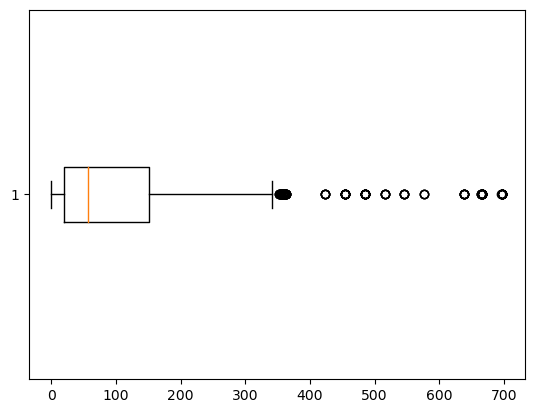

In [15]:

plt.boxplot(df_rfm['Recency'],vert=0)

plt.show()

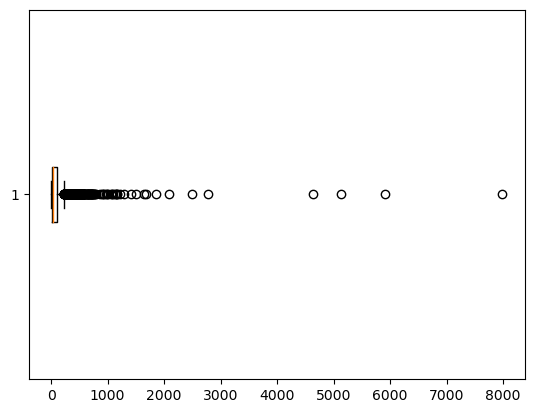

In [16]:
plt.boxplot(df_rfm['Freq'],vert=0)
plt.show()

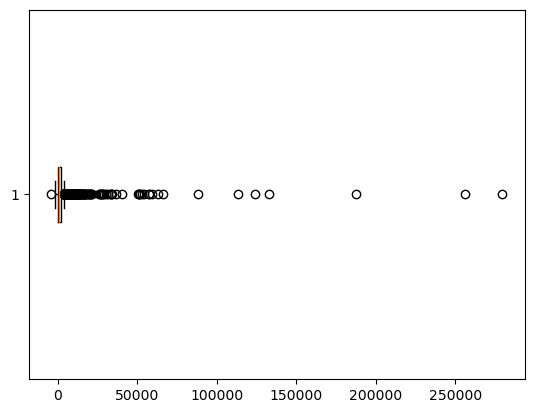

In [17]:
plt.boxplot(df_rfm['Amount'],vert=0)
plt.show()

As we can see from the boxplots there are a lot of outliers and k means clustomering algorithm is very sensitive to outliers.
We will remove the outliers, anything less that 5th percentile and greater than 95th percentile.

Q1-1.5*IQR is the lower outlier 

Q3+1.5*IQR is the higher outlier

In [18]:
Q1 = df_rfm.Amount.quantile(0.05)
Q3 = df_rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
IQR
df_rfm = df_rfm[(df_rfm.Amount >= Q1 - 1.5*IQR) & (df_rfm.Amount <= Q3 + 1.5*IQR)]

In [19]:
Q1 = df_rfm.Recency.quantile(0.05)
Q3 = df_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
df_rfm = df_rfm[(df_rfm.Recency >= Q1 - 1.5*IQR) & (df_rfm.Recency <= Q3 + 1.5*IQR)]

In [20]:
Q1 = df_rfm.Freq.quantile(0.05)
Q3 = df_rfm.Freq.quantile(0.95)
IQR = Q3 - Q1
df_rfm = df_rfm[(df_rfm.Freq >= Q1 - 1.5*IQR) & (df_rfm.Freq <= Q3 + 1.5*IQR)]

In [21]:
df_rfm.shape

(4293, 4)

In [22]:
#scaling
df_final = df_rfm[['Amount','Recency','Freq']]
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(df_final))

In [23]:
data_scaled.head()

,0,1,2
0,-0.723738,1.954651,-0.752888
1,1.731617,-0.546982,1.042467
2,0.300128,-0.232091,-0.463636
3,0.277517,-0.730668,-0.044720
4,-0.533235,1.823447,-0.603275


/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The 

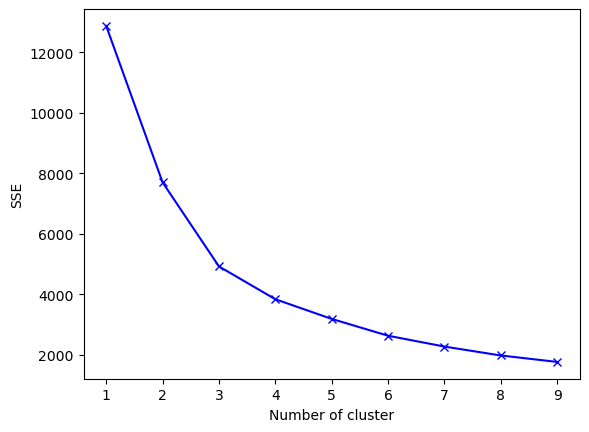

In [24]:
sse = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. 
# Use inertia attribute from the clustering object and store the inertia value for that K 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    
    sse[k] = kmeans.inertia_

# Elbow plot
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The 

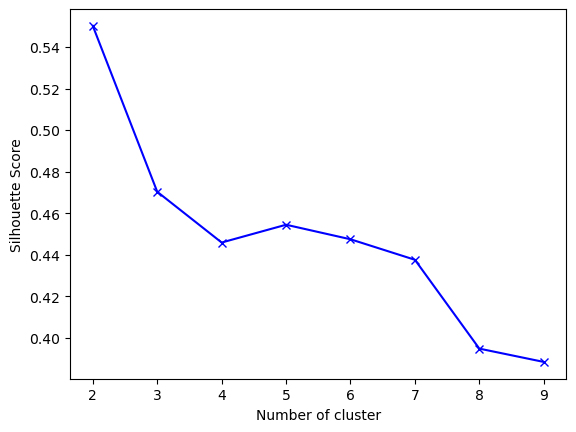

In [25]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K 
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    
    labels = kmeans.predict(data_scaled)
    
    sc[k] = silhouette_score(data_scaled, labels)

# Elbow plot
plt.figure()

plt.plot(list(sc.keys()), list(sc.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("Silhouette Score")

plt.show()

In [26]:
#model creation
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[2 0 1 ... 1 1 1]


/Users/deeptiguruprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [27]:
df_rfm['Cluster_id']=lbs
df_rfm.head()

,CustomerID,Recency,Freq,Amount,Cluster_id
0,12346.0,326,2,0.00,2
1,12347.0,40,182,4310.00,0
2,12348.0,76,31,1797.24,1
3,12349.0,19,73,1757.55,1
4,12350.0,311,17,334.40,2


In [28]:
df_rfm['KMeans_Labels'] = kmeans.predict(data_scaled)


In [29]:
df_rfm['KMeans_Labels'].value_counts()


KMeans_Labels
1    2761
2    1031
0     501
Name: count, dtype: int64

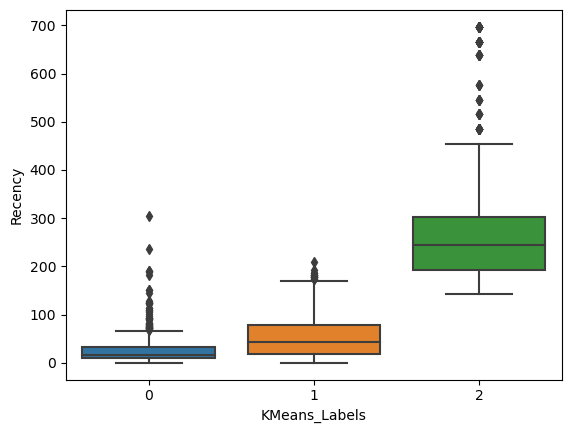

In [30]:
sns.boxplot(x='KMeans_Labels',y='Recency',data = df_rfm)
plt.show()

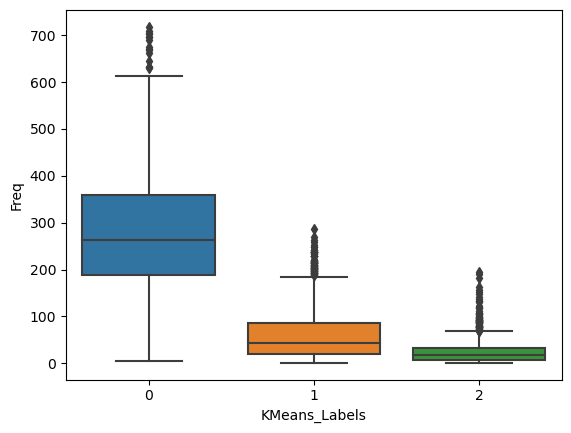

In [31]:
sns.boxplot(x='KMeans_Labels',y='Freq',data = df_rfm)
plt.show()

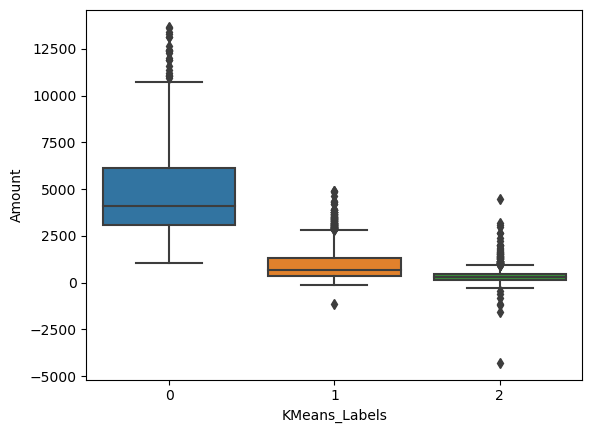

In [32]:
sns.boxplot(x='KMeans_Labels',y='Amount',data = df_rfm)
plt.show()

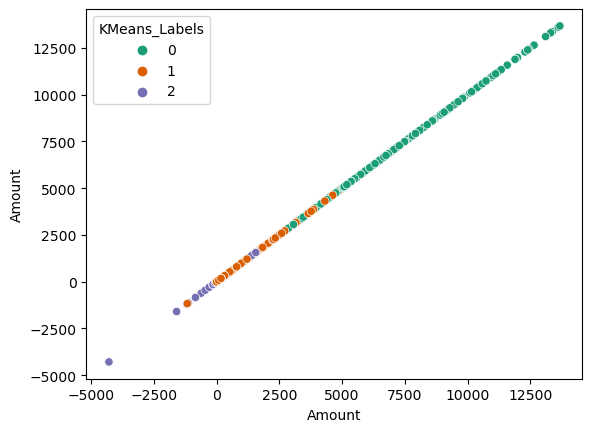

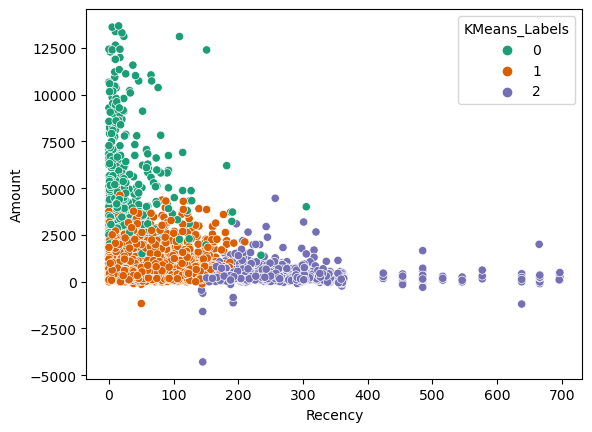

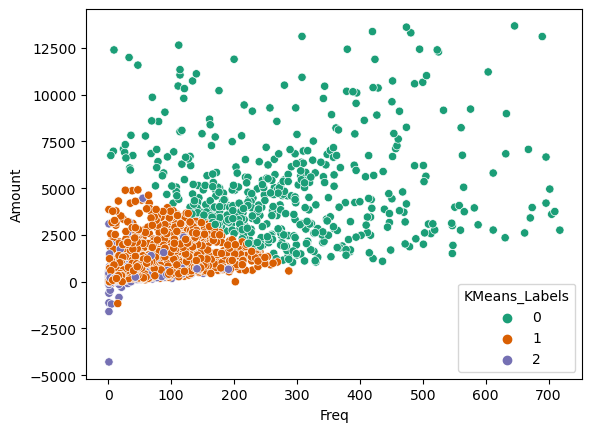

In [33]:
cols_visualise = ['Amount', 'Recency', 'Freq']
for col in cols_visualise:
    sns.scatterplot(x = col, y = 'Amount', data = df_rfm, hue = 'KMeans_Labels', palette = 'Dark2')
    
    plt.show()